In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from __future__ import print_function
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

In [3]:
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

In [4]:
df = pd.read_csv('../../../Data/faces/fer2013.csv')

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
df.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [7]:
df['pix']= df['pixels'].apply(lambda x: [int(i) for i in x.split()])

In [8]:
df.head()

,emotion,pixels,Usage,pix
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [9]:
df = df.drop('pixels',axis=1)

In [10]:
# For just happy or sad
#dfhappy = df[df['emotion']==3]
#dfsad = df[df['emotion']==4]
#dfang = df[df['emotion']==0]
#df = pd.concat([dfhappy, dfsad, dfang])

In [18]:
df['happy'] = df['emotion']==3

In [19]:
df.happy = df.happy.astype(int)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 4 columns):
emotion    35887 non-null int64
Usage      35887 non-null object
pix        35887 non-null object
happy      35887 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


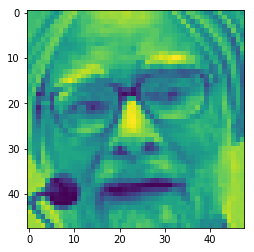

In [21]:
plt.imshow(np.asarray(df.iloc[1].pix).reshape(48,48))

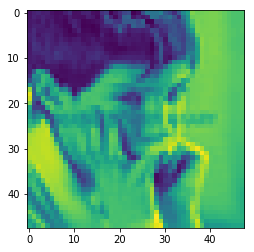

In [22]:
plt.imshow(np.asarray(df.iloc[3].pix).reshape(48,48))

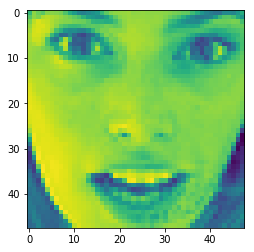

In [23]:
plt.imshow(np.asarray(df.iloc[26].pix).reshape(48,48))

In [13]:
#plt.imshow(np.asarray(df.iloc[12].resized1d).reshape(38,38))

In [24]:
from PIL import Image
test = np.asarray(df.iloc[13000].pix).reshape(48,48)


In [25]:
def reduce_quality(imageset):
    newset = []
    set1d = []
    for img in imageset:
        im = Image.fromarray(np.asarray(img).reshape(48,48).astype('uint8'))
        size =im.size   # get the size of the input image
        ratio = 0.8  # reduced the size to 80% of the input image
        reduced_size = int(size[0] * ratio), int(size[1] * ratio)     
        im_resized = im.resize(reduced_size, Image.ANTIALIAS)
        img1d = np.array(im_resized).ravel()
        newset.append(np.asarray(im_resized))
        set1d.append(img1d)
    return newset, set1d

In [26]:
newimgs, imgs1d = reduce_quality(df.pix)

In [27]:
newimgs[0].shape

(38, 38)

In [28]:
df['resize'] = newimgs

In [29]:
df['resized1d'] = imgs1d

In [30]:
df.head()

,emotion,Usage,pix,happy,resize,resized1d
0,0,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",0,"[[72, 79, 72, 57, 60, 65, 61, 59, 51, 75, 120,...","[72, 79, 72, 57, 60, 65, 61, 59, 51, 75, 120, ..."
1,0,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",0,"[[151, 148, 152, 150, 123, 124, 165, 178, 172,...","[151, 148, 152, 150, 123, 124, 165, 178, 172, ..."
2,2,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",0,"[[231, 183, 157, 168, 144, 167, 184, 184, 74, ...","[231, 183, 157, 168, 144, 167, 184, 184, 74, 3..."
3,4,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",0,"[[25, 35, 32, 31, 22, 19, 26, 37, 20, 25, 35, ...","[25, 35, 32, 31, 22, 19, 26, 37, 20, 25, 35, 2..."
4,6,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",0,"[[3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 14, 23, 35, 50...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 14, 23, 35, 50,..."


In [31]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [32]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [23]:
#df = df[df.emotion != 1]

In [33]:
df['happy'].value_counts()

0    26898
1     8989
Name: happy, dtype: int64

In [34]:
dftrain = df[df['Usage']=='Training']
X = dftrain['resized1d']
Y = dftrain['happy']

In [35]:
Xt = [i for i in X]

In [36]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 2px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((32, 32)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [37]:
#Xd, Yd = nudge_dataset(Xt, Y)

In [38]:
Xn = (Xt - np.min(Xt, 0)) / (np.max(Xt, 0) + 0.0001) 

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(Xn, Y, test_size=0.2, random_state=11)

In [40]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=50000,
                                           )
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training


rbm.learning_rate = .005
rbm.n_iter = 100

rbm.n_components = 100
logistic.C = 10000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
#raw_pixel_classifier = clone(logistic)
#raw_pixel_classifier.C = 100.
#raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -922.13, time = 5.02s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -896.77, time = 4.94s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -886.60, time = 4.84s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -873.20, time = 4.83s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -873.72, time = 4.84s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -881.70, time = 5.30s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -874.40, time = 5.28s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -863.27, time = 5.48s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -858.65, time = 5.96s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -860.22, time = 7.02s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -860.07, time = 6.67s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -854.34, time = 8.84s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -858.96, time = 5.32s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -860.78, time = 6.99s
[BernoulliRBM] 

Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.005, n_components=100, n_iter=100,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [41]:
# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

#Y_pred = raw_pixel_classifier.predict(X_test)
#print("Logistic regression using raw pixel features:\n%s\n" % (
#    metrics.classification_report(Y_test, Y_pred)))


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      4288
           1       0.55      0.11      0.18      1454

   micro avg       0.75      0.75      0.75      5742
   macro avg       0.66      0.54      0.52      5742
weighted avg       0.71      0.75      0.68      5742




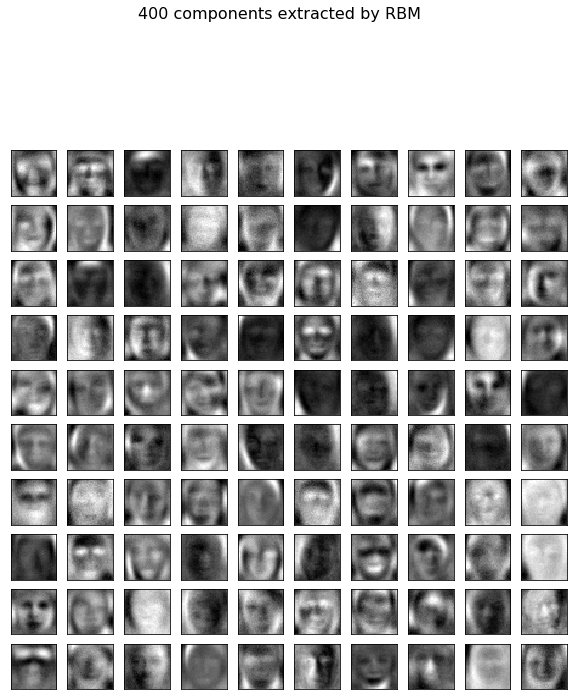

In [42]:
plt.figure(figsize=(10, 20))
for i, comp in enumerate(rbm.components_):
    plt.subplot(20, 10, i + 1)
    plt.imshow(comp.reshape((38, 38)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('400 components extracted by RBM', fontsize=16)
#plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [ ]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# initialize the RBM + Logistic Regression pipeline
rbm = BernoulliRBM(verbose=True)
logistic = LogisticRegression()
classifier = Pipeline([("rbm", rbm), ("logistic", logistic)])
 

print ("SEARCHING RBM + LOGISTIC REGRESSION")
params = {
"rbm__learning_rate": [0.01, 0.005],
"rbm__n_iter": [50, 100],
"rbm__n_components": [10, 50, 100, 200],
"logistic__C": [100, 1000, 5000]}
 
# perform a grid search over the parameter
start = time.time()
gs = GridSearchCV(classifier, params, verbose = 1, n_jobs = 4, cv=3)
gs.fit(X_train, Y_train)
 
# print diagnostic information to the user and grab the
# best model
print ("\ndone in %0.3fs" % (time.time() - start))
print ("best score: %0.3f" % (gs.best_score_))
print ("RBM + LOGISTIC REGRESSION PARAMETERS")
bestParams = gs.best_estimator_.get_params()
 
# loop over the parameters and print each of them out
# so they can be manually set
for p in sorted(params.keys()):
    print ("\t %s: %f" % (p, bestParams[p]))

SEARCHING RBM + LOGISTIC REGRESSION
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 231.8min
